<a href="https://colab.research.google.com/github/rlagosb/taller_eiv/blob/main/1_Ejercicio_Extracci%C3%B3n_(Python).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio de Extracción de Datos

En este ejercicio vamos a implementar el proceso de Extracción de una *ETL* para evaluar las brechas de consultas de especialidad en 2021 en el Servicio de Salud Metropolitano Sur Oriente. Para ello necesitamos:

1. Diseñar el área de trabajo (carpetas)
  - 📂 **Datos originales**: para este ejercicio usaremos https://github.com/rlagosb/taller_eiv/tree/main/data
  - 📂 **Datos crudos**: crearemos una carpeta en el ambiente de Colab
  - 📂 Datos normalizados (ejercicio 2)
  - 📂 Datos análisis (ejercicio 3)
2. Configurar el área de trabajo del script de Extracción
3. Cargar archivos desde la carpeta de Datos originales
4. Filtrar campos o filas innecesarios
5. Guardar los extractos en Datos crudos


# Configuración del área de trabajo

In [ ]:
# Importar librerías
import pandas as pd
import os

In [ ]:
# Definir carpetas de trabajo
datos_originales = 'https://github.com/rlagosb/taller_eiv/raw/refs/heads/main/data/'
datos_crudos = '/content/datos_crudos/'

# Crear carpeta de trabajo
if not os.path.exists(datos_crudos): os.makedirs(datos_crudos)

# Extraer REM A07 año 2021

Usaremos los Resúmenes Estadísticos Mensuales (REM) del DEIS disponibles en https://deis.minsal.cl/#datosabiertos

🔍 Los REM son informes que presentan estadísticas de producción sobre diferentes prestaciones agrupadas por región, servicio y establecimiento de salud de la red pública ([DEIS](https://deis.minsal.cl/faqs/#1719866882683-6648a718-aa6b)).

☕ Vamos a cargar los datos en un Dataframe

In [ ]:
# Cargar csv de github
url_remA07 = datos_originales + 'rem_A07_2021.txt' #  Para cargar la base de datos, se utiliza la dirección de GitHub previamente definida y se incorpora el nombre del archivo a utilizar (cargar).
rem = pd.read_csv(url_remA07,sep=";") # valores se encuentran separados por punto y comas

In [ ]:
# Revisar número de registros y tipo de campos
rem.info()

In [ ]:
# Ver una muestra aleatoria de 10 filas
rem.sample(10)

Vamos a examinar los datos de consultas para lo cual utilizamos el diccionario REM A07, Sección Consultas Médicas (archivo [SA_21_V1.2-CODIGOS.xlsx](https://github.com/rlagosb/taller_eiv/blob/eeab96f341a1338e8fa81c489afa1ad98dde7f65/data/SA_21_V1.2-CODIGOS.xlsx) en *datos_originales*)

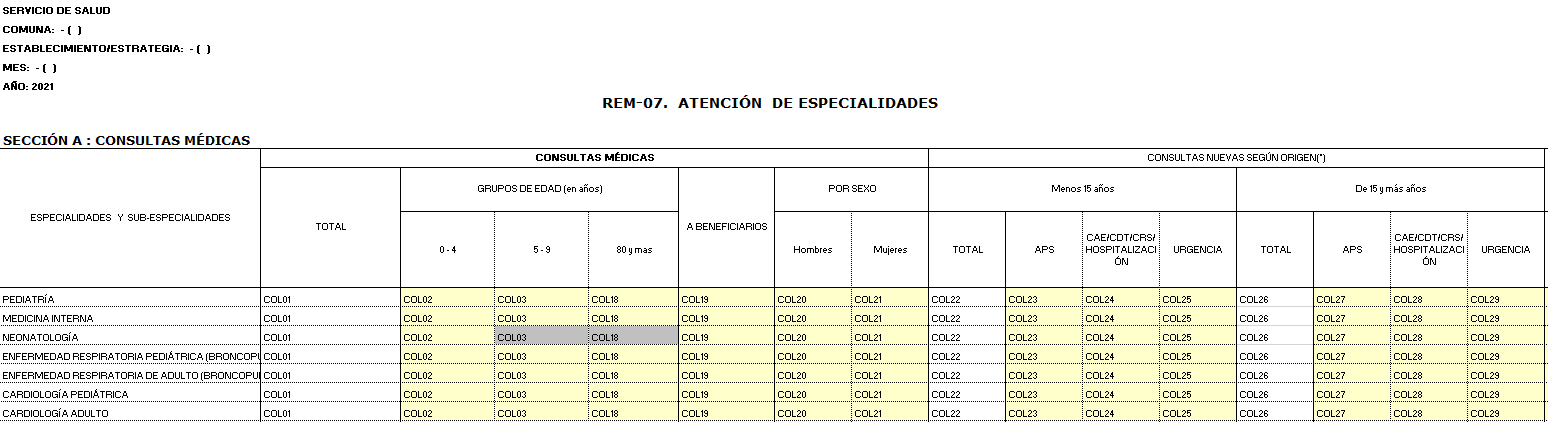

In [ ]:
# Ver la distribución de las consultas
# Tomamos las columnas [filas, columnas] Consultas, Consultas Nuevas < 15 años
# y Consultas Nuevas >= 15 años y generamos un resumen de sus datos

rem[['Col01','Col22','Col26']].describe()

In [ ]:
# Contar registros por Servicio de Salud
rem['IdServicio'].value_counts()

In [ ]:
# Contar registros de hospitales del Servicio de Salud Metropolitano Sur Oriente (IdServicio=14)
rem['IdEstablecimiento'][rem.IdServicio==14].value_counts()

In [ ]:
# Filtramos los datos de los hospitales del SSMSO
rem = rem[rem.IdServicio==14]

# Mostrar número de registros y una muestra
print(rem.info())
rem.sample(5)

In [ ]:
# Exportar a Excel
# con la base de datos rem, se exportan a la ubicación concatenada de datos crudos + nombre de archivo
rem.to_excel(datos_crudos + 'rem_A07_2021_SSMSO.xlsx',index=False)

# también exportamos con formato de extensión *.parquet
rem.to_parquet(datos_crudos + 'rem_A07_2021_SSMSO.parquet')

## 🏁 Discusión
¿Cuáles son los riesgos de modificar los datos originales en esta etapa (ejemplo: cambiar nombres de las columnas, filtrar registros)?

# Extraer solicitudes de interconsulta SIGTE

In [ ]:
# Cargar hojas de excel en dataframes

# concatenamos para definir la dirección excel_url, la cual almacena la dirección del archivo a analizar.
excel_url = datos_originales + 'SS_MSOr_Respuesta%20Solicitud%20Folio%20AO012T0001655%20(CNE%202021).xlsx'

#importamos desde esa url la hoja del excel llamada LE ABIERTA y posteriormente CNE EGRESOS
sic1 = pd.read_excel(excel_url,sheet_name='LE ABIERTA ')
sic2 = pd.read_excel(excel_url,sheet_name='CNE EGRESOS')

#exploramos los datos y sus propiedades
print(sic1.info(), end='\n\n') # agregamos dos espacios para separar las tablas
print(sic2.info())

In [ ]:
# Juntar dataframes y ver resultante
sic = pd.concat([sic1,sic2])

print(sic.info())
sic.sample(5)

In [ ]:
# Ver establecimientos de destino con más derivaciones
sic['ESTAB_DEST'].value_counts()

In [ ]:
# Filtrar derivaciones a hospitales del SSMSO
# se crea el vector centros que almacena los códigos de los hospitales pertenecientes al SSMSO

centros = [114101,114103,114105,200282] # Sótero del Río, Padre Hurtado, La Florida, Provincia Cordillera

# Se filtra la base, buscando las filas en las que
# el código del Establecimiento (ESTAB_DEST) se encuentran (isin) en el vector de centros.
sic = sic[sic.ESTAB_DEST.isin(centros)]

# Mostrar número de registros y una muestra
print(sic.info())
sic.sample(5)

## 🍎 Desafío: Exportar extracto

Exporte los datos a la carpeta *datos_crudos* con los formatos:
1. `xlsx`
2. `csv`
3. `parquet`

☕ Nota: si no recuerda los comandos puede usar la IA para generarlos.

### 🏁 Discusión

1. ¿Cuál formato es el archivo de menor tamaño?
2. ¿Cuál le parece más amigable para consultar?
3. ¿Cuál formato preferiría para almacenar los datos crudos?

# Extraer proyecciones de consultas de planillas de programación
Ahora realizaremos lo siguiente:
1. Recolección:
  - Cargar múltiples planillas en una carpeta
  - Agregar nombre de archivo
2. Consolidación
  - Unir en un dataframe
  - Exportar datos crudos (preprocesados) en excel/parquet

In [ ]:
# definimos carpeta de origen y listado de archivos a consolidar

# Observe que en el repositorio de Github, los datos se encuentran en una subcarpeta
# concatenamos datos_originales con programacion
datos_programacion = datos_originales + 'programacion/'

#definimos un vector con nombres de plantillas
planillas = ['114105_Planilla_programacion_PM_y_PNM_2021_FN_v12.xlsx',
             '114101_Planilla_programacion_PM_y_PNM_2021_FN_v12.xlsx',
             '114103_Planilla_programacion_PM_y_PNM_2021_FN_v12.xlsx',
             '200282_Planilla_programacion_PM_y_PNM_2021_FN_v12.xlsx']

In [ ]:
# cargar planillas

# creamos un dataframe vacío para consolidar los datos
consolidado = pd.DataFrame()

# leemos cada nombre de planilla
for nombre_planilla in planillas:

  # cargamos los datos de la planilla en un dataframe
  datos = pd.read_excel(datos_programacion+nombre_planilla,
                        sheet_name='Resumen Programación',
                        header=2,       # tabla empieza en la fila 3
                        usecols="B:E")  # sólo cargar datos de la columnas B:E

  # agregamos el nombre de la planilla para tener la trazabilidad del dato
  datos['Archivo'] = nombre_planilla

  # agregamos los datos al consolidado
  consolidado = pd.concat([consolidado,datos])

# revisamos la información del consolidado
print(consolidado.info())

In [ ]:
# revisamos una muestra
consolidado.sample(5)

In [ ]:
# exportamos a excel o formato preferido
consolidado.to_excel(datos_crudos + 'programacion_2021_SSMSO.xlsx',index=False)

## 🏁 Discusión

1. ¿Qué beneficios tiene guardar los datos crudos aparte de los archivos originales?
2. ¿Cuándo puede ser innecesario?
3. ¿Qué ventajas y deventajas tiene hacer esta tarea en excel?
4. ¿Qué ventajas y desventajas tiene hacer esta tarea con un lenguaje de programación?

# 🍎 Desafío: Extraer establecimientos

1. Obtenga la base de establecimientos de salud del DEIS, ubicada en la dirección: https://repositoriodeis.minsal.cl/DatosAbiertos/Establecimientos%20DEIS%20MINSAL%2007-01-2025.xlsx
  - ⚠ Note que el archivo tiene un título en la primera fila
2. Almacene el extracto en la carpeta *datos_crudos* en un formato rápido de cargar

# ANEXOS

# 📎ANEXO: Extraer REM 2021

Extracción de Resúmenes Estadísticos Mensuales (REM) del año 2021 disponibles en https://deis.minsal.cl/#datosabiertos

In [ ]:
# REM 2021
url='https://repositoriodeis.minsal.cl/DatosAbiertos/REM/SERIE_REM_2021.zip'

In [ ]:
# prompt: get file names from zip file in url

import requests
import zipfile
from io import BytesIO

def get_filenames_from_zip_url(url):
    """
    Retrieves a list of filenames from a zip file located at a given URL.

    Args:
        url: The URL of the zip file.

    Returns:
        A list of filenames contained within the zip file, or None if an error occurs.
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        with zipfile.ZipFile(BytesIO(response.content)) as z:
            return z.namelist()
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        return None
    except zipfile.BadZipFile:
        print("Error: Invalid zip file.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


filenames = get_filenames_from_zip_url(url)

if filenames:
    print("Filenames in the ZIP archive:")
    for filename in filenames:
        print(filename)
else:
    print("Could not retrieve filenames from the ZIP archive.")


In [ ]:
# prompt: read txt file '2021/SerieA_2021.txt' from zipped file

import requests
import zipfile
from io import BytesIO

# ... (Your existing code for downloading and listing files) ...

def read_txt_from_zip(url, filename):
    """Reads a text file from within a zip archive located at a given URL.

    Args:
      url: The URL of the zip file.
      filename: The name of the text file within the zip archive.

    Returns:
      A pandas DataFrame containing the data from the text file,
      or None if an error occurs.
    """
    try:
      response = requests.get(url, stream=True)
      response.raise_for_status()

      with zipfile.ZipFile(BytesIO(response.content)) as z:
          with z.open(filename) as f:
              df = pd.read_csv(f, sep=";",low_memory=False) # Adjust separator if needed
              return df
    except KeyError:
        print(f"Error: File '{filename}' not found in the zip archive.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Example usage:
df = read_txt_from_zip(url, '2021/SerieA_2021.txt')

if df is not None:
    print(df.head())

In [ ]:
df.info()

## Diccionario REM-07. ATENCIÓN DE ESPECIALIDADES
*Archivo: SA_21_V1.2-CODIGOS.xlsm*


- TOTAL CONSULTAS: COL01
- TOTAL CONSULTAS NUEVAS
  - COL22: TOTAL Menos 15 años
  - COL26: TOTAL De 15 y más años
- INASISTENTE A CONSULTA MÉDICA (NSP):
  - COL32 (NUEVAS)
  - COL33 (CONTROLES)
- COMPRA DE SERVICIO: COL41
- ALTA DE CONSULTA DE ESPECIALIDAD AMBULATORIA
  - COL37 "Menos 15 años"
  - COL38 "15 y más años"





In [ ]:
def obtener_rem():
  # Filtrar columnas
  columnas=['Mes', 'Ano', 'IdEstablecimiento', 'CodigoPrestacion',
            'IdRegion', 'IdServicio', 'IdComuna',
            'Col01','Col22','Col26','Col32','Col33','Col41','Col37','Col38']
  rem = df[columnas].copy()

  # Filtrar prestaciones (consultas médicas REM A07)
  # {07020130:'PEDIATRÍA',07020230:'MEDICINA INTERNA',07020330:'NEONATOLOGÍA',07020331:'ENFERMEDAD RESPIRATORIA PEDIÁTRICA (BRONCOPULMONAR INFANTIL)',07020332:'ENFERMEDAD RESPIRATORIA DE ADULTO (BRONCOPULMONAR)',07024219:'CARDIOLOGÍA PEDIÁTRICA',07020500:'CARDIOLOGÍA ADULTO',07020501:'ENDOCRINOLOGÍA PEDIÁTRICA',07020600:'ENDOCRINOLOGÍA ADULTO',07020601:'GASTROENTEROLOGÍA PEDIÁTRICA',07020700:'GASTROENTEROLOGÍA ADULTO',07020800:'GENÉTICA CLÍNICA',07020801:'HEMATO-ONCOLOGÍA INFANTIL',07020900:'HEMATOLOGÍA ADULTO',07020901:'NEFROLOGÍA PEDIÁTRICA',07021000:'NEFROLOGÍA ADULTO',07021001:'NUTRIÓLOGO PEDIÁTRICO',07021100:'NUTRIÓLOGO ADULTO',07021101:'REUMATOLOGÍA PEDIÁTRICA',07021230:'REUMATOLOGÍA ADULTO',07021300:'DERMATOLOGÍA',07021301:'INFECTOLOGÍA PEDIÁTRICA',07022000:'INFECTOLOGÍA ADULTO',07022001:'INMUNOLOGÍA',07021531:'GERIATRÍA',07022132:'MEDICINA FÍSICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRÍA PEDIÁTRICA)',07022133:'MEDICINA FÍSICA Y REHABILITACIÓN ADULTO (FISIATRÍA ADULTO)',07022134:'NEUROLOGÍA PEDIÁTRICA',07021700:'NEUROLOGÍA ADULTO',07021800:'ONCOLOGÍA MÉDICA',07021801:'PSIQUIATRÍA PEDIÁTRICA Y DE LA ADOLESCENCIA',07021900:'PSIQUIATRÍA ADULTO',07022130:'CIRUGÍA PEDIÁTRICA',07022142:'CIRUGÍA GENERAL ADULTO',07022143:'CIRUGÍA DIGESTIVA (ALTA)',07022144:'CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL',07022135:'CIRUGÍA PLÁSTICA Y REPARADORA PEDIÁTRICA',07022136:'CIRUGÍA PLÁSTICA Y REPARADORA ADULTO',07022137:'COLOPROCTOLOGÍA (CIRUGIA DIGESTIVA BAJA)',07022700:'CIRUGÍA TÓRAX',07022800:'CIRUGÍA VASCULAR PERIFÉRICA',07022900:'NEUROCIRUGÍA',07021701:'CIRUGÍA CARDIOVASCULAR',07023100:'ANESTESIOLOGÍA',07023200:'OBSTETRICIA',07023201:'GINECOLOGÍA PEDIÁTRICA Y DE LA ADOLESCENCIA',07023202:'GINECOLOGÍA ADULTO',07023203:'OFTALMOLOGÍA',07023700:'OTORRINOLARINGOLOGÍA',07023701:'TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA',07023702:'TRAUMATOLOGÍA Y ORTOPEDIA ADULTO',07023703:'UROLOGÍA PEDIÁTRICA',07024000:'UROLOGÍA ADULTO',07024001:'MEDICINA FAMILIAR DEL NIÑO',07024200:'MEDICINA FAMILIAR',07030500:'MEDICINA FAMILIAR ADULTO',07024201:'DIABETOLOGÍA',07024202:'MEDICINA NUCLEAR (EXCLUYE INFORMES)',07030501:'IMAGENOLOGÍA',07030502:'RADIOTERAPIA ONCOLÓGICA'}
  prestaciones = ['07020130','07020230','07020330','07020331','07020332','07024219','07020500','07020501','07020600','07020601','07020700','07020800','07020801','07020900','07020901','07021000','07021001','07021100','07021101','07021230','07021300','07021301','07022000','07022001','07021531','07022132','07022133','07022134','07021700','07021800','07021801','07021900','07022130','07022142','07022143','07022144','07022135','07022136','07022137','07022700','07022800','07022900','07021701','07023100','07023200','07023201','07023202','07023203','07023700','07023701','07023702','07023703','07024000','07024001','07024200','07030500','07024201','07024202','07030501','07030502']
  rem = rem[rem.CodigoPrestacion.isin(prestaciones)]
  return rem

remA07 = obtener_rem()
print(remA07.info())
remA07.sample(5)

In [ ]:
# Exportar a archivo csv
remA07.to_csv('rem_A07_2021.txt',sep=";")